# [Public Policy 275] Spatial Data and Analysis, Fall 2022

# Lab 7: Remote sensing, minimum distance & spatial Markov chains

## 0. Import packages
Import the packages that you need here. Remember that it is best practice to do all imports at the top of your scripts and notebooks! 

In [1]:
import random
random.seed(0)
import numpy as np
np.random.seed(0)
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import requests as re
import geopandas as gpd
from clean_line_breaks import clean_line_breaks

## 1. In the clouds

Query the NASA API

In [2]:
lat = "37.87"
lon = "-122.26" 
date = "2014-05-21"
api_key = 'g3pdmtv0UuXqr2NZ1B5rLiztdi4vAHllRHewxvXf'
base_url = "https://api.nasa.gov/planetary/earth/assets/"
image_query = base_url+"?lat="+lat+"&lon="+lon+"&date="+date
image_query = image_query + "&api_key=" + api_key
# r = re.get(image_query)
# r
# r = re.get(base_url, params={'lat': lat, 'lon': lon, 'date': date, 'api_key': api_key })
# r.json()['url']
r = re.get(base_url, params={'lat': lat, 'lon': lon, 'date': date, 'api_key': api_key })
r

<Response [200]>

In [3]:
r.json()['url']

'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ad9898181b266eec996b3c6a133b0ea3-54c6bbea53cc29a060fffa40e841dba9:getPixels'

In [4]:
def download_file(url,local_filename):
    r = re.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk:
                f.write(chunk) 
    return local_filename

nasa_reply_url = r.json()["url"]
download_file(nasa_reply_url,"image.png")

'image.png'

In [5]:
from skimage import io
im = io.imread("image.png")

### Question 1.1
What is the size of numpy array im?

In [6]:
print(im.size)
print(im.shape)

12582912
(2048, 2048, 3)


The numpy array im has three 2048 x 2048 sub-arrays, one for red, green and blue light, respectively.

### Question 1.2
The image array should have three dimensions, pixels run North-South and East-West, while there should be 3 values describing the third dimension of the array. The first layer (index=0) is the layer describing the intensity of red light observed by the satellite (known as the “red channel” or “red band”). The second layer is the green channel, and the third layer is the blue channel (hence, RGB). Use imshow to plot three images of the three channels side-by- side in black and white. These are essentially the three images you would take with a camera (from space) if you were using a red, green, or blue filter. Make sure to label and title these images properly. Is it easy to tell them apart?

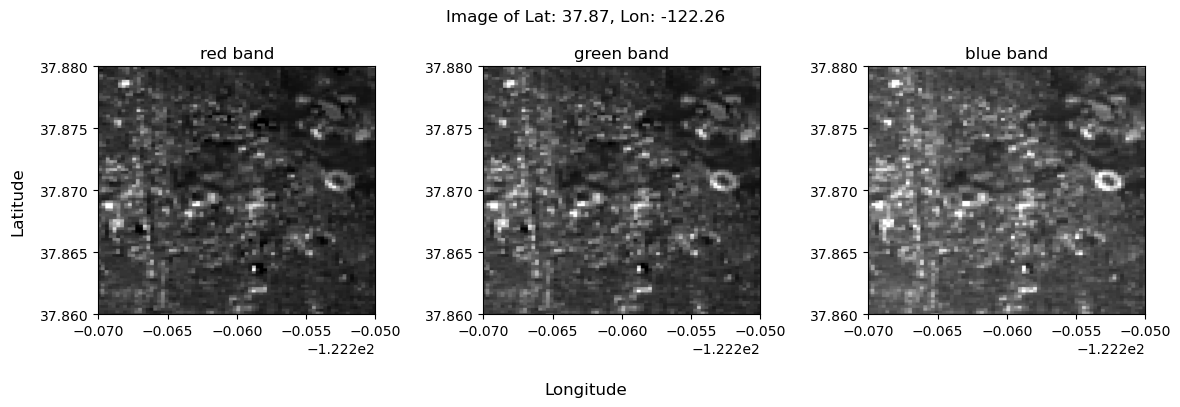

In [7]:
fig, ax = plt.subplots(1,3, figsize = (12,4))
colors = ['red', 'green', 'blue']
latitude = float(lat)
longitude = float(lon)
offset = .0125

for i in range(3):
    ax[i].imshow(im[:,:,i], cmap='gray', vmin=0, vmax=255, \
                extent=[np.round(longitude - offset,2), \
                        np.round(longitude + offset,2), \
                        np.round(latitude - offset,2), \
                        np.round(latitude + offset,2)], \
                aspect = 'auto',
                )
    ax[i].set_title('{} band'.format(colors[i]))
    
fig.suptitle('Image of Lat: {}, Lon: {}'.format(lat,lon))
fig.supxlabel('Longitude')
fig.supylabel('Latitude')
plt.tight_layout()
plt.show()

It's somehwat difficult to tell the three images apart. There are subtle differences, but in black and white, it's not obvious which image represents which color band.

### Question 1.3
The image you are looking at shows a limited area that is 0.025◦ ×0.025◦, but it’s easy to request additional images via API so you can see more. Request the image directly south of the first image and the two images directly north of the first image and concatenate (i.e. tile) them to make an image that is four times larger in terms of its coverage.

In [8]:
increment = .025
# Directly south of first image
south_lat = '37.845'
r = re.get(base_url, params={'lat': south_lat, 'lon': lon, 'date': date, 'api_key': api_key })
nasa_reply_url = r.json()["url"]
download_file(nasa_reply_url,"image.png")
im_south = io.imread("image.png")
# Directly north of first image
north_lat = '37.895'
r = re.get(base_url, params={'lat': north_lat, 'lon': lon, 'date': date, 'api_key': api_key })
nasa_reply_url = r.json()["url"]
download_file(nasa_reply_url,"image.png")
im_north = io.imread("image.png")
# Directly two north of first image
north_lat_2 = '37.92'
r = re.get(base_url, params={'lat': north_lat_2, 'lon': lon, 'date': date, 'api_key': api_key })
nasa_reply_url = r.json()["url"]
download_file(nasa_reply_url,"image.png")
im_north_2 = io.imread("image.png")

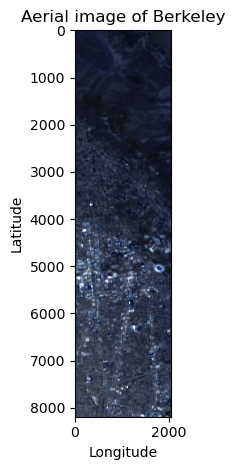

In [9]:
full_im = np.vstack((im_north_2, im_north))
full_im = np.vstack((full_im, im))
full_im = np.vstack((full_im, im_south))
north_lat_2 = float(north_lat_2)
south_lat = float(south_lat)
# Trying to plot with the appropriate extent was forcing it to be a square image
plt.imshow(full_im,)
plt.title("Aerial image of Berkeley")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

### Question 1.4
You can plot the red channel vs. green channel values for each pixel separately with the command
```python
     plt.scatter(im[:,:,0].flatten(), im[:,:,1].flatten(),alpha=0.1,s=1)
```
where the position of each pixel indicates the intensity of the two different colors of light. Also compare the green to blue channels. If you like, you can compare all three channels in a three dimensional scatter plot.

Using your larger image from question 1.3, try to isolate many of the buildings around Berkeley based on their visual properties. Note that many of the buildings in and around the campus are brighter (nearer to white) than surrounding areas that tend to be green and darker. Recall that bright colors result from a high intensity of all colors combining. So to identify buildings, look for pixels where the red, green and blue channels all take on values greater than 120 (out of a possible 255 using this 8-bit color system). **Adjust your two scatter plots so that pixels that are “bright” by this criteria (red, green and blue channels are all above 120) are colored blue and all remaining pixels are red.**

In [10]:
df = pd.DataFrame({'red': full_im[:,:,0].flatten(), \
                   'green': full_im[:,:,1].flatten(), \
                   'blue': full_im[:,:,2].flatten()})

df['threshold'] = (df>120).all(1)
df.loc[df['threshold']==True,:]

,red,green,blue,threshold
6735295,143,161,128,True
6735296,143,161,128,True
6735297,143,161,128,True
6735298,143,161,128,True
6735299,143,161,128,True
...,...,...,...,...
16776948,132,144,137,True
16776949,132,144,137,True
16776950,132,144,137,True
16776951,132,144,137,True


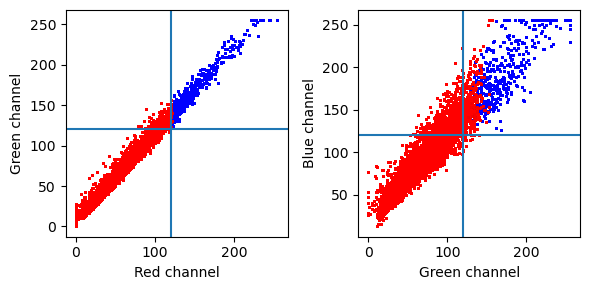

In [11]:
fig, ax = plt.subplots(1,2, figsize = (6,3))
ax[0].scatter(df[df['threshold']==True]['red'], \
              df[df['threshold']==True]['green'], \
              c = 'blue', \
              alpha=0.1, \
              s=1)
ax[0].scatter(df[df['threshold']==False]['red'], \
              df[df['threshold']==False]['green'], \
              c = 'red', \
              alpha=0.1, \
              s=1)
ax[0].set_xlabel('Red channel')
ax[0].set_ylabel('Green channel')
ax[0].axvline(120, 0,250)
ax[0].axhline(120,0,250)


# Some data points show up red in the upper right quadrant because of the value of the not plotted color
ax[1].scatter(df[df['threshold']==True]['green'], \
              df[df['threshold']==True]['blue'], \
              c = 'blue', \
              alpha=0.1, \
              s=1)
ax[1].scatter(df[df['threshold']==False]['green'], \
              df[df['threshold']==False]['blue'], \
              c = 'red', \
              alpha=0.1, \
              s=1)
ax[1].axvline(120, 0,250)
ax[1].axhline(120,0,250)
ax[1].set_xlabel('Green channel')
ax[1].set_ylabel('Blue channel')
plt.tight_layout()
plt.show()

In [12]:
# %matplotlib notebook
# # Trying to do 3-D, seems computationally difficult
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.scatter(df[df['threshold']==True]['red'], \
#            df[df['threshold']==True]['green'], \
#            df[df['threshold']==True]['blue'], \
#            c='blue', 
#            alpha=0.1,
#            s=1
#           )
# ax.scatter(df[df['threshold']==False]['red'], \
#            df[df['threshold']==False]['green'], \
#            df[df['threshold']==False]['blue'], \
#            c='red',
#            alpha=0.1,
#            s=1
#           )
# plt.show()

### Question 1.5
Again using the larger image from question 1.3, create a new array that is a mask for “bright” pixels where red, green and blue channels are all above 120. Plot this mask using imshow in a panel next to your true color image. Did you do a good job isolating the buildings in the image? If you think you can do better, try varying the brightness cutoffs of the different channels to see if you can improve performance. Extra optional challenge: Can you plot the building-pixels you’ve identified in their normal full color, but plot the rest of the image in white, i.e. erasing everything that’s not a building?

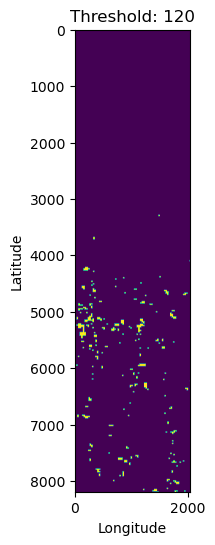

In [13]:
def identify_buildings(image, threshold):
    image = ((image[:,:,2]>threshold) & (image[:,:,1]>threshold) & (image[:,:,0]>threshold))
    return image
bright_image = identify_buildings(full_im, 120)
fig = plt.figure(figsize=(8,6))
plt.imshow(bright_image)
plt.title('Threshold: 120')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

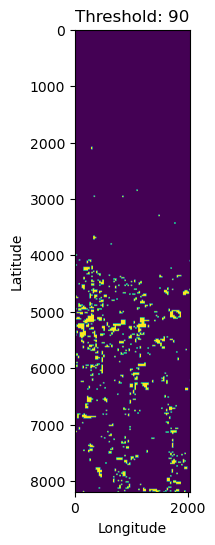

In [14]:
bright_image = identify_buildings(full_im, 90)
fig = plt.figure(figsize=(8,6))
plt.imshow(bright_image)
plt.title('Threshold: 90')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Setting the threshold at 120 seemed too high (it was erasing the distinctive circle of the stadium), so I tried a threshold of 100 and then 90. 90 seems like it is picking up on many of the buildings in downtown, and on campus, while filtering out many smaller buildings and other image structures in the neighborhoods.

## 2. How many cats could a camera catch if a camera could catch cats?

### Question 2-1

**Write a script (perhaps with functions) that will make a snow leopard wander for ten days.
Verify that your code is working properly by turning in a figure illustrating a snow-
leopard’s path during 10 days (output from one simulation).**

In [15]:
def is_valid(this_move):
    """
    Inputs: This_move, a numpy array of eight possible moves around the current position
    Output: A numpy array stating whether each move is valid (e.g. within the grid or not)
    """
    return np.all((this_move <=9) & (this_move>=0), axis=1)

def wander(position, num_days):
    """
    Inputs: Position, an arbitrary location on the 10x10 grid; num_days, the number of days to wander
    Output: The path of the snow leopard starting at position and moving for num_days
    """
    current = np.array(position)
    path = [current]
    possible_moves = np.array([
        [1,0], # move right
        [-1,0], # move left
        [0,1], # move up
        [0,-1], # move down
        [1,1], # move diagonal up right
        [-1,-1], # diagonal down left
        [1,-1], # diagonal down right
        [-1,1], # diagonal left up
    ])
    # Select and take one grid cell steps each day for num_days
    for i in range(num_days):
        this_move = current + possible_moves
        mask = is_valid(this_move)
        move_index = np.random.choice(len(possible_moves[mask==True]))
        next_position = current + possible_moves[mask==True][move_index]
        path.append(next_position)
        current = next_position
    return np.array(path)

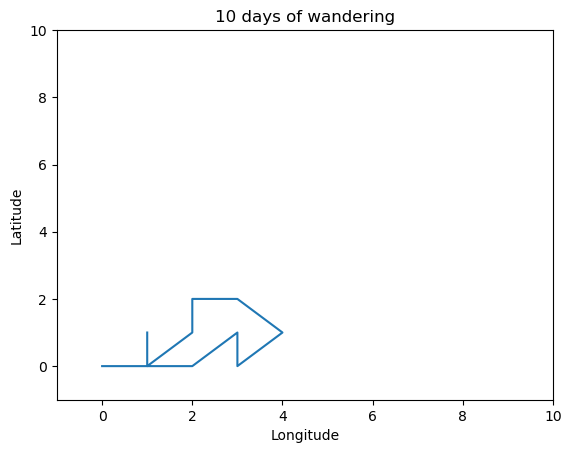

In [16]:
# Now make a plot of the path
np.random.seed(0)
path = wander([0,0], 10)
fig,ax = plt.subplots(1,1)
plt.title("10 days of wandering")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim(-1,10)
plt.ylim(-1,10)
ax.plot(path[:,0], path[:,1])
plt.show()

### Question 2-2

**Run your code for 100 days and make a plot of the snow leopard’s path in the 10 km x 10 km space over the entire study.**

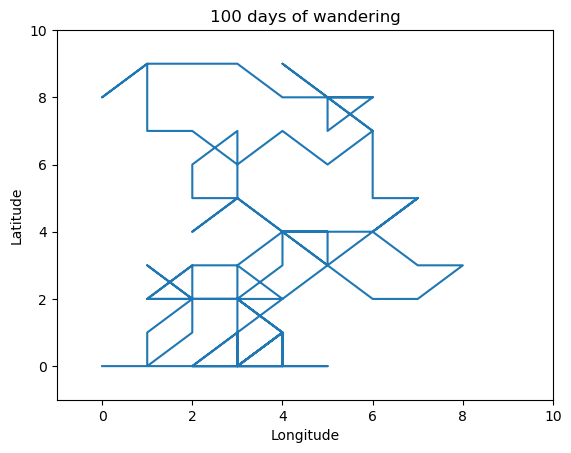

In [17]:
np.random.seed(0)
path = wander([0,0], 100)
fig,ax = plt.subplots(1,1)
plt.xlim(-1,10)
plt.ylim(-1,10)
plt.title("100 days of wandering")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
ax.plot(path[:,0], path[:,1])
plt.show()

### Question 2-3

**Turn in a figure with three subplots showing the paths of three separate snow leopards over the course of the study to show that it works.**

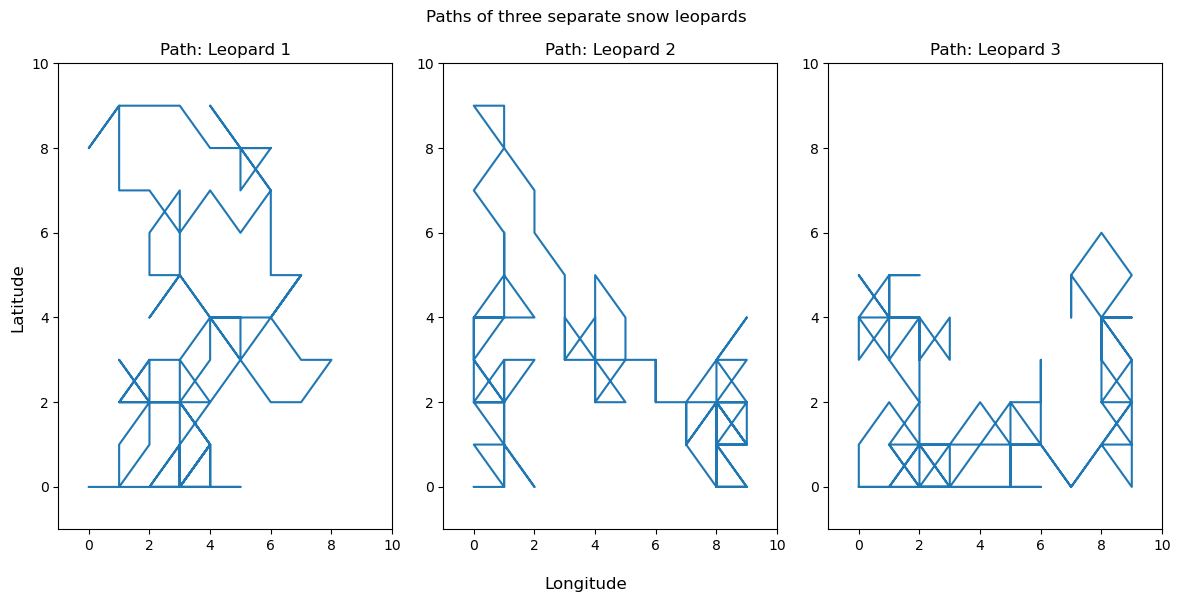

In [18]:
np.random.seed(0)
fig, axes = plt.subplots(1,3, figsize=(12,6))
for i in range(3):  
    path = wander([0,0], 100)
    axes[i].plot(path[:,0], path[:,1])
    axes[i].set_xlim(-1,10)
    axes[i].set_ylim(-1,10)
    axes[i].set_title(f'Path: Leopard {i+1}')
fig.supxlabel('Longitude')
fig.supylabel('Latitude')
fig.suptitle('Paths of three separate snow leopards')
plt.tight_layout()
plt.show()

### Question 2-4

When you are confident that your simulation is doing what you want it to do, “set up” our simulated camera in cell (3,3). 

This means every period, keep track of whether there is a snow leopard in that cell. 

Because camera traps are elaborate and must be reset after taking a shot (something our field research team can only afford to do daily for this project), we can’t take photos of two snow leopards in the same day, so if there is more than one animal in cell (3,3) on a given day, we only take a photo of one. (Alternatively, you can think of our camera as always only recording whether there was at least one snow leopard in the cell on a given day). 

For every day of the 100-day study, you should have either a zero or a one recorded for whether there was a snow leopard at (3,3). 

**Demonstrate that your camera is “working” by showing two subplots in a single plot.**

**The first is the paths of 3 animals over the study, with the location of the camera marked with a “*”.**

**The second is a time series of the observations made by the camera.**

Confirm that your record shows the same number of observations as your map of snow leopard paths.

In [19]:
def wander_c(start, days, camera):
    current = start
    path = [current]
    camera_count = []
    possible_moves = np.array([
        [1,0], # move right
        [-1,0], # move left
        [0,1], # move up
        [0,-1], # move down
        [1,1], # move diagonal up right
        [-1,-1], # diagonal down left
        [1,-1], # diagonal down right
        [-1,1], # diagonal left up
    ])
    for day in range(days):
        camera_count.append(
            tuple(current) == tuple(camera)) # 
        possible = current + possible_moves
        valid = possible[is_valid(possible)]
        choice = np.random.choice(len(valid))
        current = valid[choice]
        path.append(current)
    return np.array(path), np.array(camera_count)

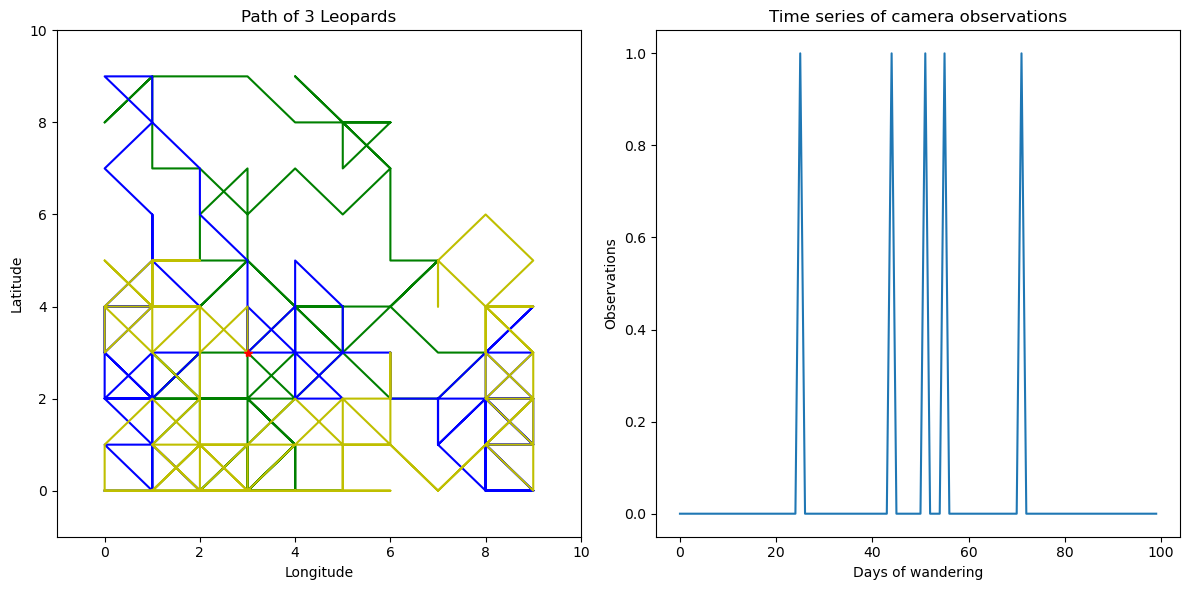

In [20]:
# Write your code here
np.random.seed(0)
fig, ax = plt.subplots(1,2, figsize=(12,6))

path0, c0 = wander_c(start = np.array([0, 0]), days = 100, camera = np.array([3, 3]))
path1, c1 = wander_c(start = np.array([0, 0]), days = 100, camera = np.array([3, 3]))
path2, c2 = wander_c(start = np.array([0, 0]), days = 100, camera = np.array([3, 3]))

x = ax[0].plot(path0[:, 0], path0[:, 1], 'g', label='Path 1')
ax[0].plot(path1[:, 0], path1[:, 1], 'b', label='Path 2')
ax[0].plot(path2[:, 0], path2[:, 1], 'y', label='Path 3')
ax[0].plot(3, 3, 'r*', label='Camera location')
ax[0].set_xlim(-1,10)
ax[0].set_ylim(-1,10)
ax[0].set_title('Path of 3 Leopards')
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Latitude")
# axes[0].legend() # Figure out what's going on with legend

c_all = c0 | c1 | c2
ax[1].plot(c_all*1)
ax[1].set_title("Time series of camera observations")
ax[1].set_ylabel("Observations")
ax[1].set_xlabel("Days of wandering")

plt.tight_layout()
plt.show()

### Question 2-5

Assume there are N'=1 leopards walking around. Record the M times the camera captures this leopard, based on 1000 simulations of 100 days of randomly wandering. Construct a histogram of the number of photos taken.

In [21]:
np.random.seed(0)

def wander_markov(start, days, camera):
    current = start
#     path = [current]
    camera_count = []
    possible_moves = np.array([
        [1,0], # move right
        [-1,0], # move left
        [0,1], # move up
        [0,-1], # move down
        [1,1], # move diagonal up right
        [-1,-1], # diagonal down left
        [1,-1], # diagonal down right
        [-1,1], # diagonal left up
    ])
    for day in range(days):
        camera_count.append(
            tuple(current) == tuple(camera)) # 
        possible = current + possible_moves
        valid = possible[is_valid(possible)]
        choice = np.random.choice(len(valid))
        current = valid[choice]
#         path.append(current)
    return np.array(camera_count)

sighting_count = []
for _ in range(1000):
    start = np.array([np.random.choice(10), np.random.choice(10)])
    camera = wander_markov(start, days=100, camera = np.array([3, 3]))
    sighting_count.append(sum(camera))

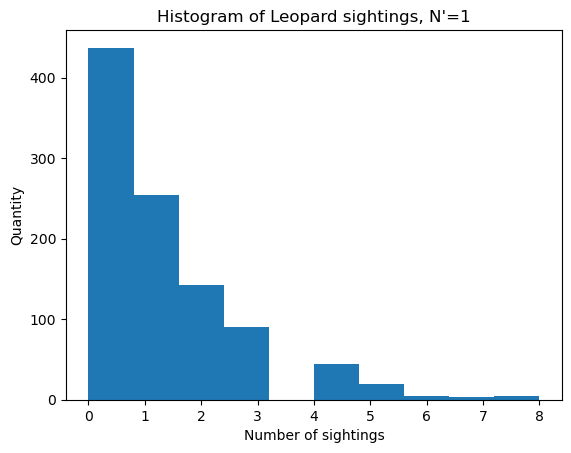

In [22]:
plt.hist(sighting_count)
plt.title("Histogram of Leopard sightings, N'=1")
plt.xlabel("Number of sightings")
plt.ylabel("Quantity")
plt.show()

In [23]:
sighting_count = pd.DataFrame(sighting_count)
sighting_count.value_counts()
probability = 19/1000
probability

0.019

Given 1000 iterations for N'=1, Prob(M=5|N=N') is 0.019.

Now, add one to N', and make code iterable for N.

In [24]:
def simulate_n_leopards(iterations, days, num_leopards, camera_location=np.array([3,3])):
    sighting_count = np.ones([num_leopards, iterations])
    for j in range(iterations):
        if j%100==0:
            print(j)
        start = np.array([np.random.choice(10), np.random.choice(10)])
        camera_list = []
        for i in range(num_leopards):
            camera = wander_markov(start, days, camera_location)
            camera_list.append(camera)
            c_test = camera_list[0]
            for k in range(len(camera_list)-1):
                c_test = c_test | camera_list[k+1]
            sighting_count[i][j] = sum(c_test*1)
    return sighting_count
   
np.random.seed(0)
import time
start_time = time.time()
test = simulate_n_leopards(1000,100,12)
print("--- %s seconds ---" % (time.time() - start_time))

0
100
200
300
400
500
600
700
800
900
--- 38.57947492599487 seconds ---


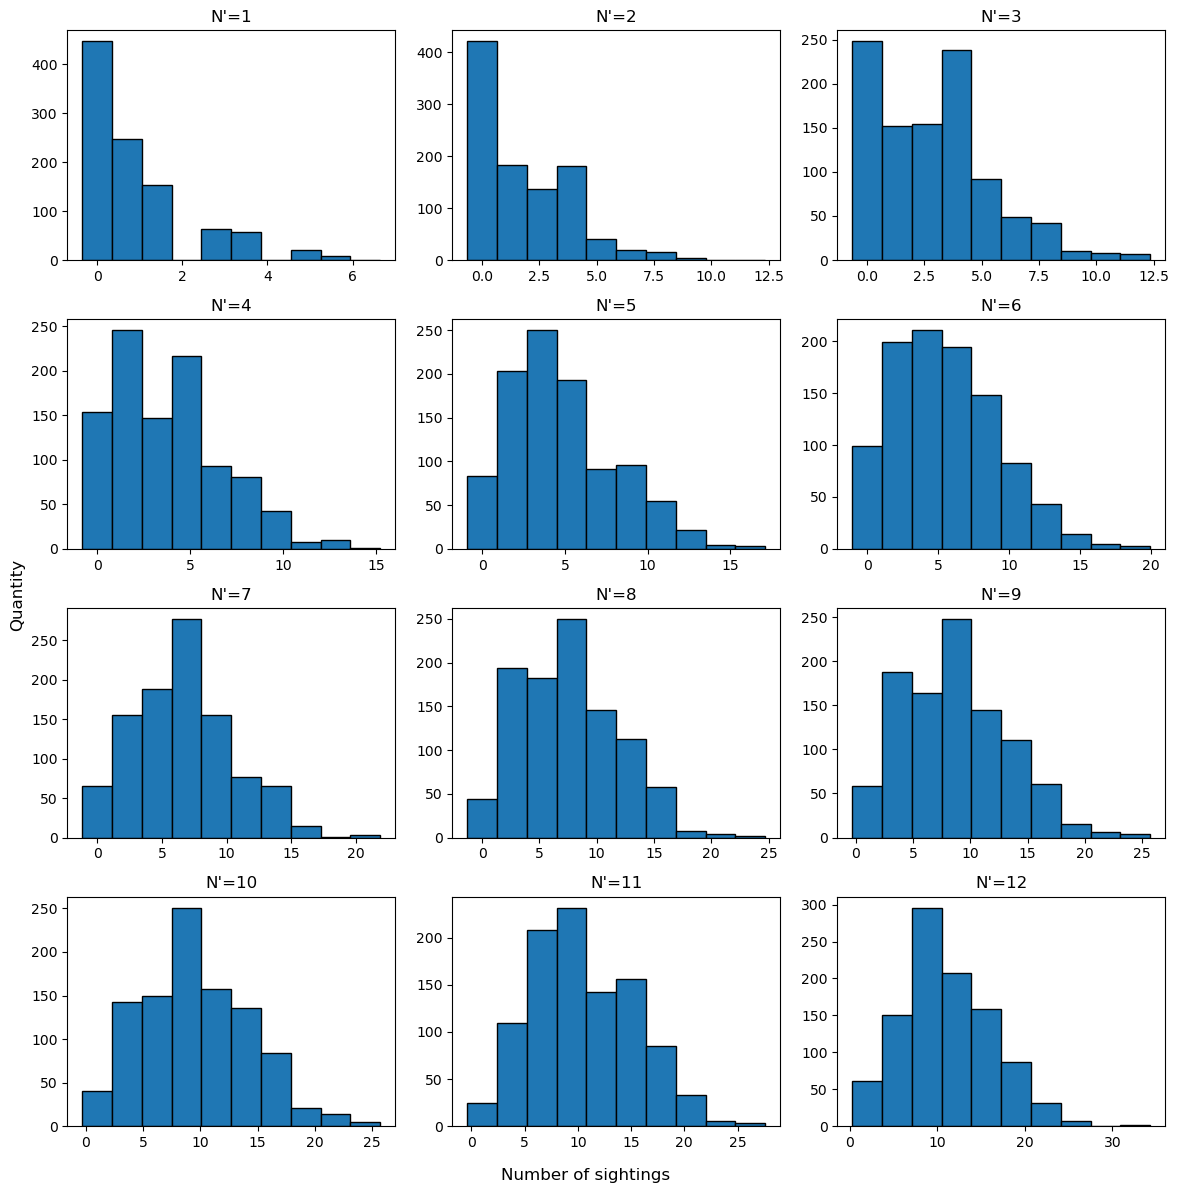

In [25]:
fig, ax = plt.subplots(4,3,figsize=(12,12))
count = 0
for l in range(4):
    for m in range(3):
        ax[l][m].hist(test[count], align='left', edgecolor='black')
        count = count + 1
        ax[l][m].set_title(f"N'={count}")
fig.supxlabel("Number of sightings")
fig.supylabel("Quantity")
plt.tight_layout()
plt.show()

In [26]:
test = pd.DataFrame(test)
probabilities = []
for i in range(test.shape[0]): 
    probabilities.append(test.loc[i,:].to_frame().value_counts()[5]/1000)
probabilities

[0.021,
 0.07,
 0.096,
 0.114,
 0.12,
 0.107,
 0.092,
 0.075,
 0.052,
 0.04,
 0.033,
 0.024]

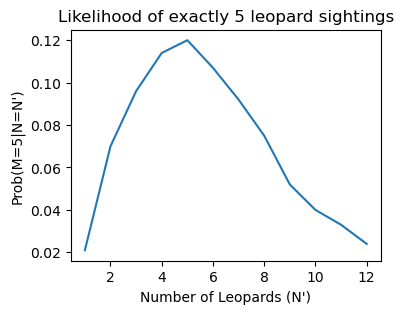

In [27]:
plt.figure(figsize=(4,3))
plt.plot((np.arange(12) + 1), probabilities)
plt.title("Likelihood of exactly 5 leopard sightings")
plt.xlabel("Number of Leopards (N')")
plt.ylabel("Prob(M=5|N=N')")
plt.show()

Since P(M=5|N=N') is maximized for N'=5 (~0.114), $\hat{N}$, our best estimate for N, equals 5.

### Question 2-6

Determine
whether our original location, (3,3), or (1,1) or (5,5) produce more precise or noisier samples.
Do this by running the simulation 1,000 times for N = 3 snow leopards for each of these camera
positions (don’t forget that you’ve already done this for (3,3)). Compare the variances of the
distributions for M(x,y), the number of sightings made by the camera at (x, y). Which
location provides an expected distribution with the smallest variance? (The function
np.var() will be useful). Which location produces a distribution with the largest
variance? Interpret what this means. If you had done this simulation before the
field experiment was conducted, where would you recommend placing the camera? Why?


In [28]:
np.random.seed(0)
one_one = pd.DataFrame(simulate_n_leopards(1000,100,3, np.array([1,1])))
five_five = pd.DataFrame(simulate_n_leopards(1000,100,3, np.array([5,5])))

0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900


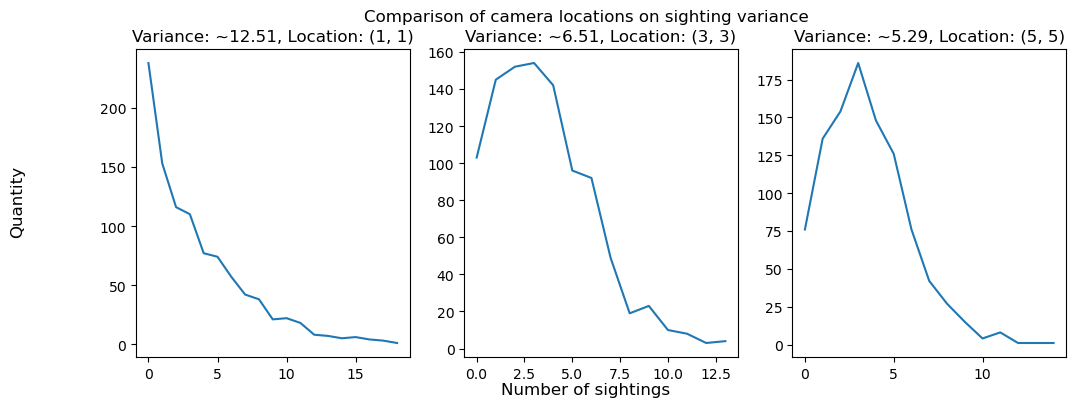

In [29]:
fig, ax = plt.subplots(1,3,figsize=(12,4))
# Plotting distribution for location (1,1)
ax[0].plot(one_one.loc[2,:].value_counts().sort_index())
x=np.around(one_one.loc[2,:].to_frame().var().values[0], decimals=2)
y=(1,1)
ax[0].set_title(F"Variance: ~{x}, Location: {y}")

# Plotting distribution for location (3,3)
ax[1].plot(test.loc[2,:].value_counts().sort_index())
x=np.around(test.loc[2,:].to_frame().var().values[0], decimals=2)
y=(3,3)
ax[1].set_title(F"Variance: ~{x}, Location: {y}")

# Plotting distribution for location (5,5)
ax[2].plot(five_five.loc[2,:].value_counts().sort_index())
x=np.around(five_five.loc[2,:].to_frame().var().values[0], decimals=2)
y=(5,5)
ax[2].set_title(F"Variance: ~{x}, Location: {y}")

# Overall plot labels
fig.suptitle("Comparison of camera locations on sighting variance")
fig.supxlabel("Number of sightings")
fig.supylabel("Quantity")
plt.show()

Setting the camera at location (5,5) produces an expected distribution of leopard sightings with the smallest variance. Setting the camera at location (1,1) produces an expected distribution with the largest variance. This makes sense, given we are simulating a 10x10 grid, and allowing for random start locations for leopards. Location (5,5) is the exact center of the grid, meaning a leopard that randomly starts at (10,10) is much more likely to wander to (5,5) than (1,1) or (3,3). However, a leopard that starts at (0,0) is very likely to cross (1,1), less likely to cross (3,3) and even less likely to cross (5,5). That's why the variance of camera location (1,1) is so high. Because it is close to a corner, if lots of leopards happen to be in that corner, it will capture them. But if the leopards are in other parts of the grid, it is very unlikely to capture them.

Given this understanding of camera location variance, I would have placed the camera at location (5,5) if given the opportunity before the field experiment was conducted. We're trying to estimate the true population of snow leopards with as much precision as possible. Although (1,1) and (3,3) might randomly capture more leopards if they happen to be close to a corner, I would trust the outcomes of (5,5) more given the lower variance. 

## 3. As the crow flies and as the railcar rolls...

The government of South Africa is considering building a major grain storage facility to buffer the national economy from the impacts of future climate change. There are many parameters to consider when deciding where to place the facility, but transport costs is a major factor. Your job is help the government understand the transport distances involved with placing a facility at different nodes in the nation’s rail network. Because grain must be carried by train, your analysis will focus on minimum distances along the railroad network.

As policy-makers consider different facility locations, they will need to see the distribution of transport distances for that location. However, because they do not yet know all the factors they will ultimately consider, they have not asked you to optimize the placement of the facility. Instead, they have asked you to develop an interactive tool that will allow them to quickly analyze any potential site by simply specifying its location. The tool’s specification is that a user must be able to tell your program a location and your program should output (1) a map depicting transport distances to all other nodes in the network and (2) a histogram of these distances. (For this problem it is okay to compute distances in degrees, but you can convert to km if you like).

### Question 3-1

Begin by downloading the shape file for South Africa's railroad network

In [30]:
df = gpd.read_file('ZAF_rrd/ZAF_rails.shp')

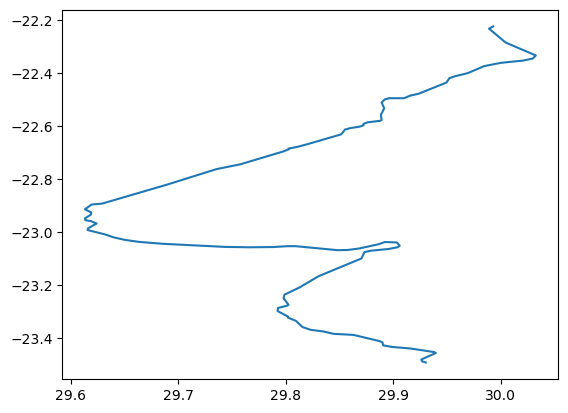

In [31]:
index = 0
plt.plot(df['geometry'][index].xy[0], df['geometry'][index].xy[1])
plt.show()

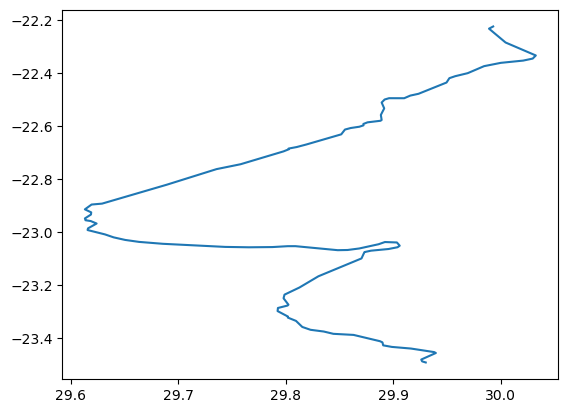

In [32]:
df = clean_line_breaks(df)
plt.plot(df['geometry'][index].xy[0], df['geometry'][index].xy[1])
plt.show()

### Question 3-2

In [33]:
df['geometry'].shape

(497,)

Text(0.5, 1.0, 'South African railroad network')

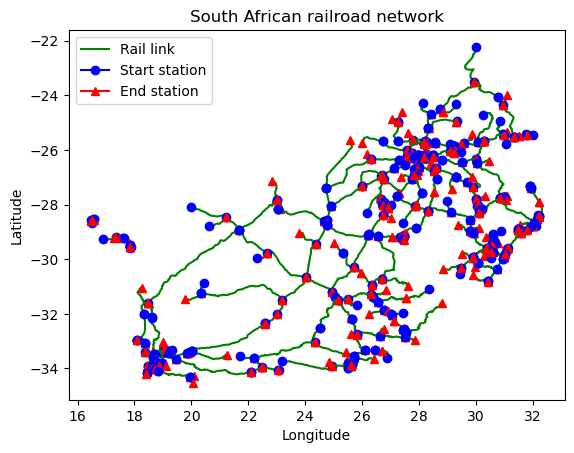

In [34]:
for i in range(len(df)):
    line_lats, line_lons = df['geometry'][i].xy
    plt.plot(df['geometry'][i].xy[0], df['geometry'][i].xy[1], 'g')
    plt.plot(line_lats[0], line_lons[0], color='blue', marker='o')
    plt.plot(line_lats[-1], line_lons[-1], color='red', marker='^')
plt.plot([],[], 'g', label='Rail link')
plt.plot([],[], 'blue', marker='o', label='Start station')
plt.plot([],[], 'red', marker='^', label='End station')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("South African railroad network")

### Question 3-3

In [35]:
start_lats, start_lons = [], []
end_lats, end_lons = [], []
for i in range(len(df)):
    line_lats, line_lons = df['geometry'][i].xy
    start_lats.append(line_lats[0])
    start_lons.append(line_lons[0])
    end_lats.append(line_lats[-1])
    end_lons.append(line_lons[-1])

duplicates_df = pd.DataFrame({"start_lats": start_lats, "start_lons": start_lons, "end_lats": end_lats, "end_lons": end_lons})   

list_with_duplicates = np.array(list(zip(start_lats+end_lats, start_lons+end_lons)))
stations = np.unique(list_with_duplicates, axis=0)

In [36]:
indices = np.unique(list_with_duplicates, axis=0, return_index=True)[1]
indices.shape

(457,)

There are 457 unique stations in the network.

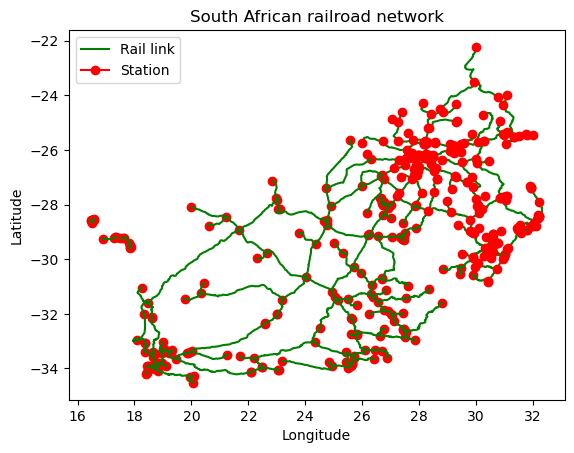

In [37]:
for i in range(len(df)):
    plt.plot(df['geometry'][i].xy[0], df['geometry'][i].xy[1], 'g')
    if i < len(stations):
        plt.plot(stations[i,0],stations[i,1], color='red', marker='o')   
plt.plot([],[], 'g', label='Rail link')
plt.plot([],[], 'red', marker='o', label='Station')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("South African railroad network")
plt.show()

### Question 3-4

Now that you have a list of the station positions, you are ready to compute the adjacency matrix and the corresponding distance matrix. Begin by first constructing the adjacency matrix L describing which stations are directly linked to other stations. Start by constructing a large matrix of zeros where each station gets a row and column. Then go through the rail links one by one and determine which station is the start station, which is the end station, and add a one to the matrix to record that the two are stations are connected. Once you have added a one to the adjacency matrix for each rail link then you know that you have the entire matrix since there can’t be any more links. The indexing here gets a little tricky here because you have to search through the nodes to find which one is at the start/end of each link:

In [38]:
L = np.zeros((len(stations), len(stations)))
for i in range(len(df)):
    line_lats, line_lons = df['geometry'][i].xy
    for j in range(len(stations)):
        if np.sum([line_lats[0], line_lons[0]]==stations[j,:])==2:
            start_j = j
        if np.sum([line_lats[-1], line_lons[-1]]==stations[j,:])==2:
            end_j = j
    L[start_j, end_j]=1
    L[end_j, start_j]=1
    
L

array([[1., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

Once this runs, check that the adjacency matrix looks like you expect using imshow. For this adjacency matrix, notice that we did not fill in the diagonal, i.e. we do not list that each location is connected to itself.

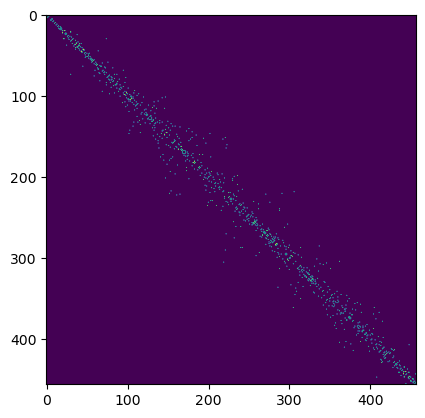

In [39]:
plt.imshow(L)
plt.show()

Now adjust this code to build the distance matrix D, where instead of using a one/zero to denote whether two stations are connected, you list the distance between two locations if they are connected (computed along the rail link that the connects them) and infinity if they are not connected (you should not use zero to denote that two stations are not connected because you might later confuse this with zero distance, i.e. that the two stations are very close together). Hint: you may wish to write a function that computes the travel distance along a rail link – this will likely save you time since each rail link is a polyline with a different number of segments describing it, and you will have to replicate this calculation over 400 times.

Visualize D using imshow, does it look the way you expected?

For the following parts of the problem (building the program for the South African government) you will use D as the starting point, i.e. you don’t need to recompute D each time the program runs (you may want to save it and have your program load it each time it runs – try pickling it).

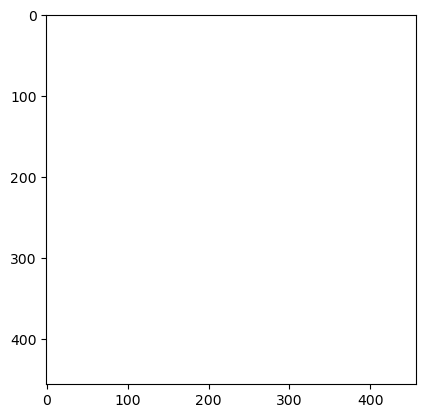

In [40]:
# Ok, so I remembered df['geometry'][i].length after I wrote this...
# But I checked that they get the same answer!
def link_distance(link):
    """
    Input: link, a geopandas linestring object
    Output: Total distance to travel along the link
    """
    lats, lons = link.xy
    distance = 0
    for i in range(len(lats)-1):
        # Calcualting distance between each segment
        curr_dist = np.sqrt((lats[i+1]-lats[i])**2+((lons[i+1]-lons[i])**2))
        # Adding to distance counter
        distance = distance + curr_dist
    return distance
    
def define_D(default_value):
    D = np.ones((len(stations), len(stations)))*default_value
    for i in range(len(df)):
        line_lats, line_lons = df['geometry'][i].xy
        distance = link_distance(df['geometry'][i])
        for j in range(len(stations)):
            if np.sum([line_lats[0], line_lons[0]]==stations[j,:])==2:
                start_j = j
            if np.sum([line_lats[-1], line_lons[-1]]==stations[j,:])==2:
                end_j = j
        D[start_j, end_j]=distance
        # Confirming this calculated distance is equivalent to df['geometry'][i].length
#         print(distance)
#         print(df['geometry'][i].length)
        D[end_j, start_j]=distance
    return D
D = define_D(np.inf)
plt.imshow(D, cmap='Purples', vmin=-.1)
plt.show()

Since we've set the distance between two stations to infinity if they don't have a connection, plt.imshow plots a blank white image. If we change the value we use to represent no connection to a finite value, the image looks similar to the one plotted for L.

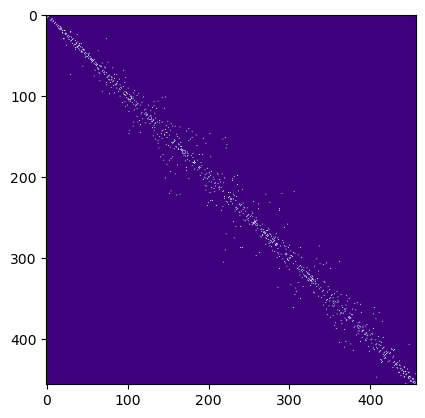

In [41]:
D = define_D(1000)
plt.imshow(D, cmap='Purples')
plt.show()

### Question 3-5

Now that you have simplified the network into its distance matrix, implement the algorithm to compute the shortest distance from an arbitrary station k (the potential location for the grain facility) to all other stations in the network. Follow the steps in the algorithm covered in class. Check that the output is correct for some short and obvious distances. Once you think it is working correctly for longer distances, check by having it plot the shortest path between stations 20 and 200 overlaid on the complete rail network. Your station 20 and 200 may not be the same, so make sure that station 20 is located at the coordinates [18.0726, -32.9397] and station 200 is at [27.2609, -25.6663]. If this isn’t the case, you can look up the index of the station corresponding to the coordinates above using the code np.where(stations == [ 27.2609, -25.6663]), to find station “20”. (You may need to look in stations.round(4) if your coordinates of stations haven’t yet been rounded to four decimal places). Your code should output a single vector describing the distance from k to each station along the shortest path.

In [42]:
# resetting D for no connections to be np.inf
D = define_D(np.inf)

In [43]:
# Confirming that my stations 20 and 200 are the same as intended
print(stations[20])
print(stations[200])

[ 18.0726 -32.9397]
[ 27.2609 -25.6663]


In [44]:
def shortest_distances(i, dists):
    # Define three vectors for Dijkstra's Algorithm
    d_vector = np.ones(len(stations)) * np.inf
    P = np.ones(len(stations)) * np.nan
    I = np.zeros(len(stations))
    
    #Set distance for start node to 0
    d_vector[i]=0
    
    while not all(I==1):
        # Check which nodes have not yet been visited
        not_visited_ids = np.where(I==0)[0]
        j = not_visited_ids[np.argmin(d_vector[not_visited_ids])]

        # Replace I(j) = 1
        I[j] = 1

        # Loop over all other nodes
        # Can loop over all other nodes b/c of inf
        for k in range(len(d_vector)):
            if (I[k]==0) & ((d_vector[j] + dists[j,k]) < d_vector[k]):
                d_vector[k] = d_vector[j] + dists[j,k]
                P[k] = j
    return d_vector, P

d1, p1 = shortest_distances(20,D)

In [45]:
def construct_path(start, end, parent_vector, distance_vector):
    """
    Inputs: start - the node we're starting at; 
            end - the node we're ending at; 
            parent_vector - the vector of parent nodes for the path from start to end
    """
    next_node = end
    path = [next_node]
    # print('Start at node {}.'.format(next_node))
    while (not np.isnan(next_node)):
        next_node = parent_vector[next_node]
        if not np.isnan(next_node):
            next_node = int(next_node)
            path.append(next_node)
    #         print(f'Then go to {next_node + 1}.')
    return path, distance_vector[path]

path, distance_vector = construct_path(20, 200, p1, d1)

# Ensuring my code outputs a vector describing the distance from k to each station along the shortest path
print("Path: {}".format(path))
print("-------")
print("Distances: {}".format(distance_vector))

Path: [200, 232, 276, 271, 222, 231, 228, 227, 220, 202, 197, 159, 156, 138, 107, 104, 101, 91, 87, 74, 30, 22, 20]
-------
Distances: [16.76342326 16.2238121  15.81376317 15.76035427 14.99382437 14.75597167
 14.68949048 14.64095962 14.44867646 14.18550117 13.8169744  13.27358436
 13.20860293 12.43487447 11.08303945 10.55232122 10.44748303  8.40384911
  8.08640517  6.24448086  1.68914147  1.08688828  0.        ]


In [46]:
def normalize_distances(dist_vector, factor, invert=False):
    """
    Input: dist_vector - A vector representing distances in a network
           factor - an integer value (to normalize that data between 0 and that value)
           invert - whether or not to normalize large values to the factor value, or small values
    Output: A vector of the same size, normalized between 0 and 1, multipled by factor value
    """
    if np.max(dist_vector)==np.inf:
        maximum = np.unique(dist_vector)[-2]
    else:
        maximum = np.max(dist_vector)
    minimum = np.min(dist_vector)
    if not invert:
        normalized_distances = ((dist_vector - minimum) / (maximum - minimum) ) * factor
    if invert:
        normalized_distances = factor - ((dist_vector - minimum) / (maximum - minimum) ) * factor
        
    for i in range(len(normalized_distances)):
        if normalized_distances[i]==np.inf:
            normalized_distances[i]=factor
        if normalized_distances[i]==-np.inf:
            normalized_distances[i]=0

    return normalized_distances

In [47]:
def plot_path(path, stations, duplicates_df, df, dist_vector, factor=255, invert=False, \
              plot_network=True, plot_path=True, include_warning=False):
    """
    Inputs: path - list of node connections
            stations - numpy array of unique stations in the network
            duplicates_df - Pandas dataframe with columns representing lat/lon for start and end nodes for each line
            df - GeoPandas dataframe with geometry column of linestrings representing station connections
            dist_vector - A vector representing distances in a network
            factor - an integer value (to normalize that data between 0 and that value)
            invert - whether or not to normalize large values to the factor value, or small values
            include_warning - whether or not to include warning that no path exists
            
    Outputs: Plot of stations and connections for shortest path, with options to plot the whole network
    """
    if plot_network:
        for i in range(len(df)):
            plt.plot(df['geometry'][i].xy[0], df['geometry'][i].xy[1], 'y')
        plt.plot([],[], 'y', label='Rail link')
    
    for i in range(len(stations)):
        plt.plot(stations[i,0],stations[i,1], color='red', marker='o', markersize=3.5)
    plt.plot([],[], 'red', marker='o', label='Station')
    
    if plot_path:
        for k in range(len(path)-1):
            # Extract lats and lons for stations at either end of line
            start_lat = stations[path[k]][0]
            start_lon = stations[path[k]][1]
            end_lat = stations[path[k+1]][0]
            end_lon = stations[path[k+1]][1]

            # Identify index in original dataframe for that exact line
            index = duplicates_df[(\
            # Checking instances where the path is going from start -> end
            (duplicates_df['start_lats']==start_lat) \
             & (duplicates_df['start_lons']==start_lon) \
             & (duplicates_df['end_lats']==end_lat) \
             & (duplicates_df['end_lons']==end_lon))\
            # Checking instances where the path is going from end -> start
            | ((duplicates_df['start_lats']==end_lat) \
             & (duplicates_df['start_lons']==end_lon) \
             & (duplicates_df['end_lats']==start_lat) \
             & (duplicates_df['end_lons']==start_lon))\
            ].index[0]

            if plot_path:
                # Normalize shortest path distance vector 
                normalized_path_distances = normalize_distances(distance_vector, factor=factor, invert=invert)

                # Plot that line
                plt.plot(df['geometry'][index].xy[0], df['geometry'][index].xy[1], \
                # choosing to have the color to be shades of green, based on distance
                    color=(0/255,normalized_path_distances[k]/255,0/255))

                # Plot current station
                plt.plot(stations[path[k]][0], stations[path[k]][1], color='blue', marker='*')

                # Plot last station if at end of list
                if k == len(path)-2:
                    plt.plot(stations[path[k+1]][0], stations[path[k+1]][1], color='blue', marker='*')

        # Add to legend
        plt.plot([],[], 'blue', marker='*', label='Shortest Path Station')
        plt.plot([],[], 'g', label='Shortest path')
            
    if (len(path)==1) & include_warning:
        plt.text(25,-29,"No possible path exists", \
                 backgroundcolor='white', \
                 horizontalalignment='center')
    
    plt.legend()
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title("South African railroad network")

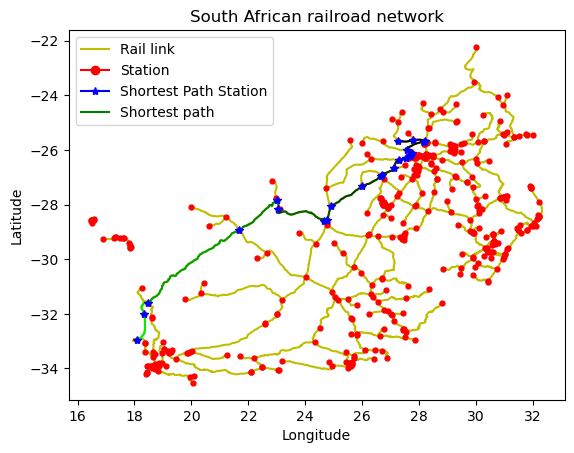

In [48]:
plot_path(path, stations, duplicates_df, df, distance_vector, invert=True)

### Question 3-6

Finally, build the user interface that the South African government requested. When your program runs, it should start by prompting the user to input a potential station site using the input function:

```python
k = input('Station for facility?  Enter 0 to '+ str(len(stations)-1)+': ')
```

It should then compute the minimum distance for station k to all other station locations. It should then output a plot with two subplots. The first should show each station as a marker overlaid on the rail network, with stations colored based on their distance from the grain facility. The second subplot should show a histogram of these distances. Make sure these plots are labeled well so that when government planners work with your program, they know exactly what they are looking at in these plots.

**Check that your code works by running it three times, trying out grain facilities at stations 100, 250, and 360. Turn in all three of these final plots.**

Confirm that station 100 is at the coordinates [24.5089, -32.526], station 250 is at [27.9465, - 26.6757], and station 360 is at [29.9004, -27.3609], otherwise use the stations that correspond to those values. (Note that those coordinates have been rounded, you may need to round your coordinates to four decimal points to have stations at those values).

In [49]:
# Confirming station 100, 250 and 360 are at expected coordinates
print("Station 100: {}".format(stations[100]))
print("Station 250: {}".format(stations[250]))
print("Station 360: {}".format(stations[360]))

Station 100: [ 24.5089 -32.526 ]
Station 250: [ 27.9465 -26.6757]
Station 360: [ 29.9004 -27.3609]


In [50]:
# print(k)
def run_program():
    k = input('Station for facility?  Enter 0 to '+ str(len(stations)-1)+': ')
    k=int(k)
    D = define_D(np.inf)
    dk, pk = shortest_distances(k,D)
    fig, ax = plt.subplots(1,2,figsize=(12,6))

    for i in range(len(df)):
        ax[0].plot(df['geometry'][i].xy[0], df['geometry'][i].xy[1], 'y')

    station_distances = []
    dist_hist = []
    for i in range(len(stations)):
        path_i, distance_vector_i = construct_path(k, i, pk, dk)
        if distance_vector_i[0]==np.inf:
            station_distances.append(distance_vector_i[0])
            dist_hist.append(-1)
        else:
            station_distances.append(distance_vector_i[0])
            dist_hist.append(distance_vector_i[0])


    normalized_distances = normalize_distances(station_distances, factor=255, invert=True)
    for i in range(len(stations)):
        ax[0].plot(stations[i,0],stations[i,1], color=(normalized_distances[i]/255, 0/255, 0/255), marker='o', markersize=4)

    ax[0].plot(stations[k,0],stations[k,1], color='b', marker='*', markersize=8, label='Possible facility')

    ax[0].plot([],[], 'y', label='Rail link')
    ax[0].plot([],[], 'red', marker='o', label='Station')
    ax[0].legend()
    ax[0].set_ylabel("Latitude")
    ax[0].set_xlabel("Longitude")
    ax[0].set_title("Distances to {}".format(k))


    ax[1].hist(dist_hist, bins=20, align='left', edgecolor='black')
    ax[1].set_title("Histogram of station distances")
    ax[1].set_ylabel("Count")
    ax[1].set_xlabel("Distance from node to stations")
    ax[1].text(7.5,-10,'Note: np.inf coded as -1', horizontalalignment='center')
    cmap = plt.get_cmap('Reds')
    norm = mpl.colors.Normalize(vmin=0,vmax=255)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, ax=ax[0])
    
    plt.tight_layout()

Station for facility?  Enter 0 to 456: 100


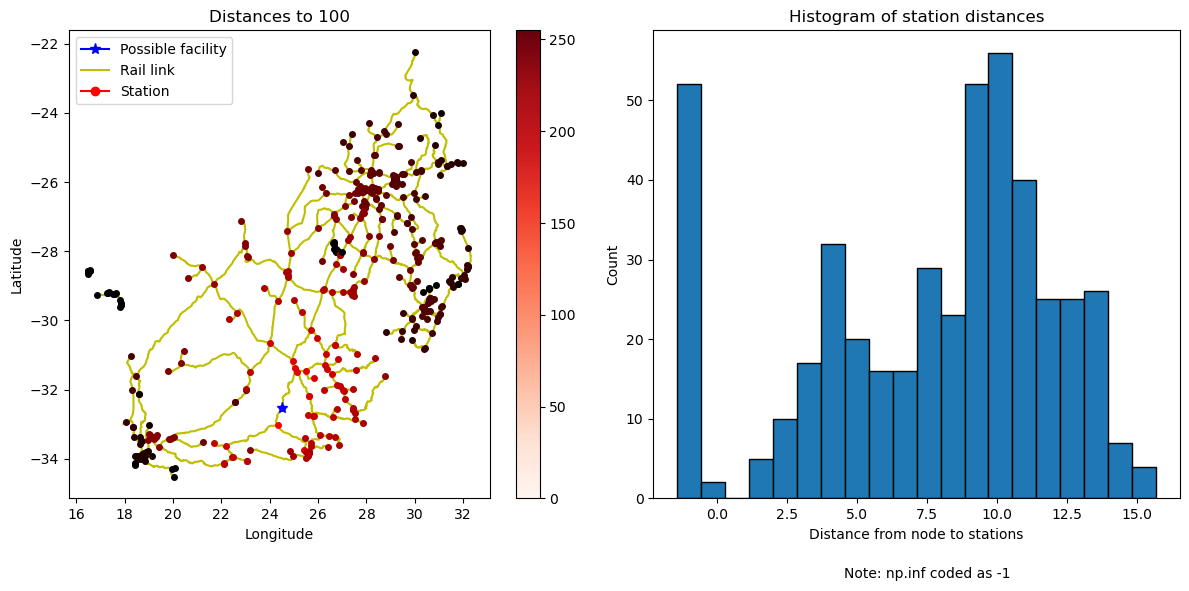

In [51]:
# Run program for k=100
run_program()

Station for facility?  Enter 0 to 456: 250


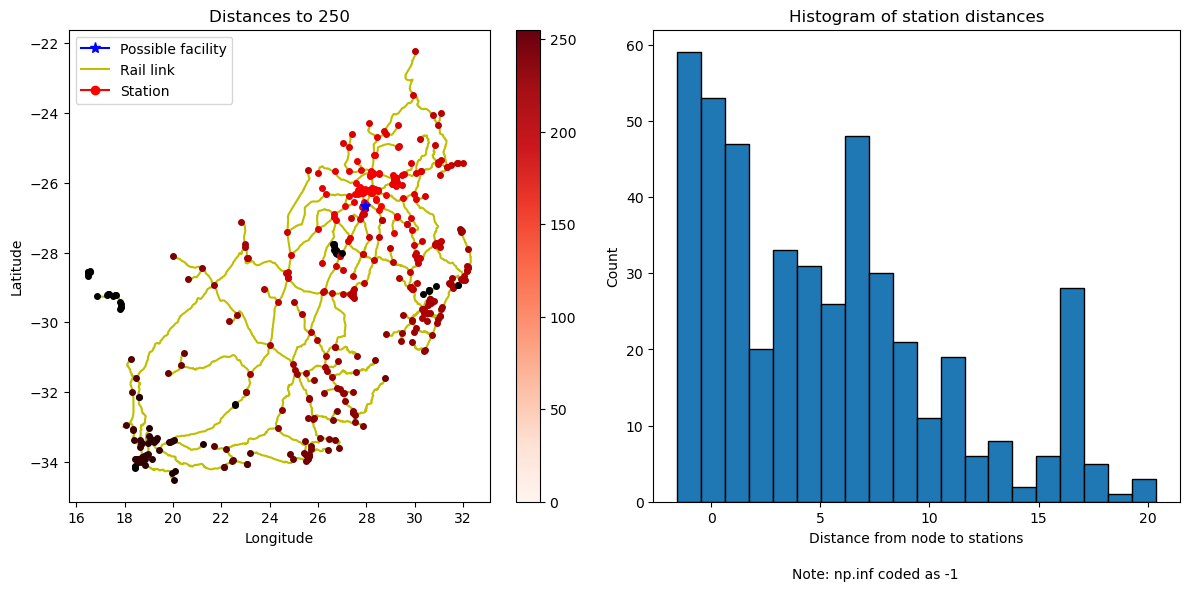

In [52]:
# Run program for k=250
run_program()

Station for facility?  Enter 0 to 456: 360


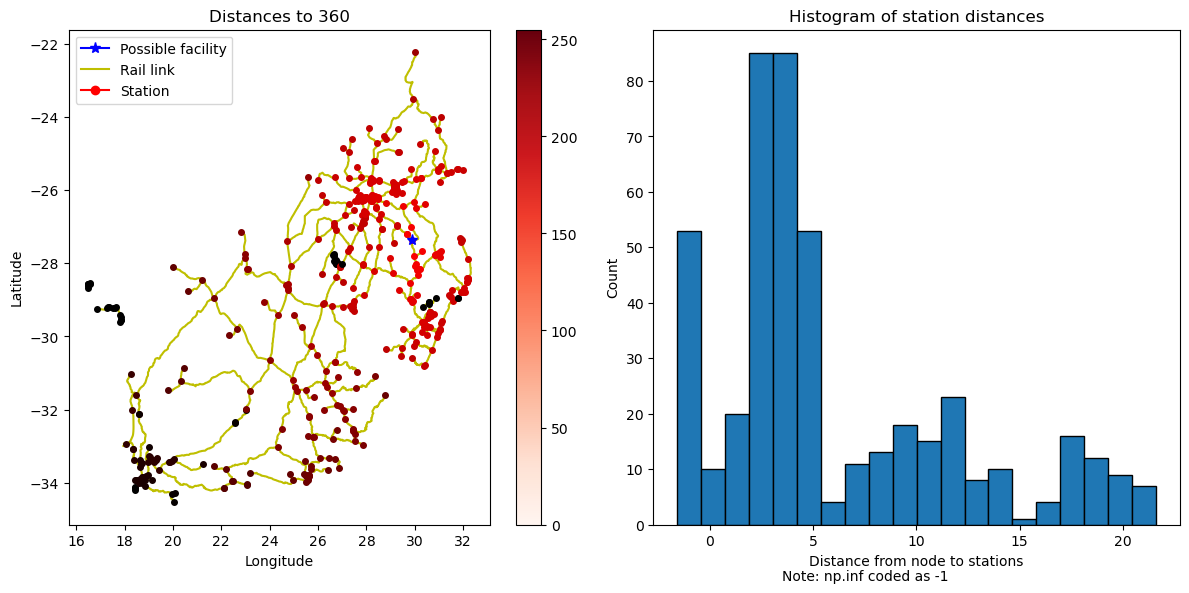

In [53]:
# Run program for k=360
run_program()

## Extra Credit - MOSAIKS